O seguinte notebook descreve uma série de experimentos conduzidos para treinar um modelo de aprendizado de máquina com o propósito de classificar imagens do conjunto de dados Snapshot Serengeti. Este conjunto de dados é composto por uma extensa coleção de imagens de animais selvagens capturadas no Parque Nacional Serengeti, localizado na Tanzânia, e pode ser acessado por meio do seguinte link: [Snapshot Serengeti](https://lila.science/datasets/snapshot-serengeti).

No processo de treinamento, foram utilizadas imagens das primeiras e décimas temporadas, com uma etapa inicial de segmentação dos dados. Esta segmentação visava identificar as classes mais frequentes, ou seja, aquelas com um número significativamente superior a 300 imagens disponíveis. Esse procedimento resultou na seleção de 15 classes principais para o treinamento.

No início do experimento, empregamos uma arquitetura de rede neural convolucional (CNN) conhecida como Resnet-18, previamente treinada em um grande conjunto de dados. Esta abordagem inicial mostrou resultados consideráveis, alcançando uma taxa de precisão de aproximadamente 85% após várias rodadas de treinamento.

Em seguida, realizamos outros experimentos utilizando uma CNN mais simples, a AlexNet. No entanto, os resultados obtidos com a AlexNet foram inferiores em comparação com a Resnet-18, resultando em uma taxa de precisão de cerca de 77%.

Essa série de experimentos ilustra a importância da escolha da arquitetura da rede neural no desempenho de tarefas de classificação de imagens. Embora a Resnet-18 tenha apresentado um desempenho superior para o conjunto de dados do Snapshot Serengeti, a AlexNet pode ainda ser útil em cenários específicos ou como ponto de partida para futuras otimizações do modelo.

In [ ]:
#Bibliotecas utilizadas
import os
import time
import torch
import torchvision
import torchvision.transforms as T
from skimage import io
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
from PIL import Image
from torch.nn.parallel import DataParallel

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [7]:
if torch.cuda.is_available():
    # Obter o número de GPUs disponíveis
    num_gpus = torch.cuda.device_count()
    print(f"Total de GPUs disponíveis: {num_gpus}")

    # Loop para cada GPU
    for i in range(num_gpus):
        gpu_device = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory
        gpu_memory_free = torch.cuda.memory_reserved(i) - torch.cuda.memory_allocated(i)
        gpu_memory_used = torch.cuda.memory_allocated(i)

        print(f"\nGPU {i}: {gpu_device}")
        print(f"Memória total: {gpu_memory/(1024**2):.2f} MB")
        print(f"Memória utilizada: {gpu_memory_used/(1024**2):.2f} MB")
        print(f"Memória livre: {gpu_memory_free/(1024**2):.2f} MB")
else:
    print("CUDA não está disponível.")

Total de GPUs disponíveis: 2

GPU 0: NVIDIA GeForce RTX 2080 Ti
Memória total: 11016.31 MB
Memória utilizada: 0.00 MB
Memória livre: 0.00 MB

GPU 1: NVIDIA GeForce GTX TITAN X
Memória total: 12212.88 MB
Memória utilizada: 0.00 MB
Memória livre: 0.00 MB


In [8]:
n = 0
train_l_sum = 0.0
train_acc_sum = 0.0
start = time.time()

#Hiperparâmetros para treinamento da Rede Neural 
args = {
    'batch_size': 256,
    'num_workers': 4,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'num_classes': 13,    # Number of KKCs.

}




In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [10]:
#Clase para utilização de um conjunto de dados personalizados

class AnimalImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations['image_path_rel'][index]
        image = io.imread(img_name)
        y_label = torch.tensor(self.annotations['label'][index])

        if self.transform:
            image = self.transform(image)

        return image, y_label

### Modelo ###

A ResNet18 é uma rede neural convolucional pré-treinada com 18 camadas, amplamente utilizada em tarefas de classificação de imagens. Sua eficiência é comprovada por ser relativamente pequena em comparação com outras arquiteturas mais profundas, o que requer um desempenho computacional menor. A ResNet18 é pré-treinada em grandes conjuntos de dados, como o ImageNet, permitindo que ela aprenda recursos básicos de baixo nível.

In [26]:
model = torchvision.models.alexnet(pretrained=False)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#Define e retorna os dataloaders
def load_data():
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size = args['batch_size'],
                              shuffle=True,
                              pin_memory = True,
                              num_workers=4)

    val_loader =  DataLoader(dataset=val_dataset,
                             batch_size = args['batch_size'],
                             shuffle=False,
                             pin_memory = True,
                             num_workers=4)

    return train_loader, val_loader


#Obtém a acurácia da rede em cima de um conjunto de dados
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n, l = torch.Tensor([0]), 0, 0
    net.eval()
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            # Apply the model
            y_hat = net(X)
            l += loss(y_hat, y).sum()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
    return acc_sum.item() / n, l.item() / len(data_iter)


#Treinamento e validação
def train_validate(model, train_iter, test_iter, optimizer, loss, num_epochs):
    print('training on', device)
    for epoch in range(num_epochs):
        model.train()
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            optimizer.zero_grad()
            l = loss(y_pred, y).sum()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_pred.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, model, loss)
        train_losses.append(train_l_sum / len(train_iter))
        train_correct.append(train_acc_sum / n)
        test_losses.append(test_loss)
        test_correct.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, ''test acc %.3f, time %.1f min' % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss, test_acc, (time.time() - start) / 60))



#Checa a acurácia e outras métricas(Precision, Recall, F1) no conjunto de testes
def check_accuracy_test(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            
        accuracy = float(num_correct) / float(num_samples) * 100
        f1 = f1_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        
        print(f'Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')
        
        cm = confusion_matrix(y_true, y_pred)
        classes = np.arange(23)
        fig, ax = plt.subplots(figsize=(15, 15))  # Set the figsize parameter to increase the size of the image
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               ylabel='True label',
               xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        
        return

## Primeiro Treinamento ##

In [14]:
args

{'batch_size': 256,
 'num_workers': 4,
 'num_epochs': 50,
 'learning_rate': 0.001,
 'num_classes': 13}

In [15]:
train = pd.read_csv('training_data_d1.csv')
val = pd.read_csv('validation_data_d1.csv')
test = pd.read_csv('testing_data_d1.csv')

In [16]:
#Tamanho dos dados de treino, teste e validação
train.shape, test.shape, val.shape

((13055, 8), (4350, 8), (4352, 8))

In [17]:
train = train[0:1000]
val = val[0:500]
test = test[0:500]

### Data Augmentation ###
Para o treinamento, foi utilizada a técnica de Data Augmentation, que consiste em uma técnica de pré-processamento de dados usada para aumentar o tamanho do conjunto de dados, através da geração de novas amostras. Para gerar novas amostras, diversas transformações podem ser realizadas, como rotações, reflexões, escalas, translações, entre outras. Essa técnica permite aumentar a diversidade e a variação dos dados, o que resulta em um melho desempenho e generalização do modelo. 

In [20]:
train.to_csv('train_1000samples.csv')
test.to_csv('test_1000samples.csv')
val.to_csv('val_1000samples.csv')

In [21]:
transform = T.Compose([
    T.ToPILImage(),
    T.RandomGrayscale(0.5),
    T.RandomAutocontrast(0.5),
    T.RandomHorizontalFlip(0.5),
    T.Resize(224),
    T.ColorJitter(brightness=(0.5,1.5)),
    T.ToTensor()
])

train_dataset = AnimalImageDataset(csv_file = 'train_1000samples.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'val_1000samples.csv', root_dir = '', transform = transform)

In [24]:
#Salva os dados utilizados para treinamento da rede neural convolucional

train_features = []
train_labels = []

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    train_features.append(image)
    train_labels.append(label)

# Converta a lista de características em um tensor
train_features = torch.stack(train_features)

# Converta a lista de rótulos em um tensor
train_labels = torch.stack(train_labels)
train_data = {
    'features': train_features,
    'labels': train_labels
}

torch.save(train_data, '../CATALOGO_VALE/train_data_1000n.pth')

In [27]:
#Definição da função de perda e do otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = args['learning_rate'])

In [29]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
#Treinamento
train_iter, val_iter = load_data()

start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')

training on cuda:1
epoch 1, train loss 5.9821, train acc 0.187, test loss 4.3536, test acc 0.228, time 0.1 min
epoch 2, train loss 5.1681, train acc 0.194, test loss 4.0962, test acc 0.116, time 0.1 min
epoch 3, train loss 3.8594, train acc 0.125, test loss 3.4987, test acc 0.116, time 0.1 min
epoch 4, train loss 3.2513, train acc 0.125, test loss 2.7701, test acc 0.116, time 0.1 min
epoch 5, train loss 2.5173, train acc 0.153, test loss 2.4421, test acc 0.228, time 0.1 min
epoch 6, train loss 2.3229, train acc 0.254, test loss 2.3512, test acc 0.248, time 0.1 min
epoch 7, train loss 2.2863, train acc 0.279, test loss 2.3575, test acc 0.248, time 0.1 min
epoch 8, train loss 2.2508, train acc 0.279, test loss 2.3359, test acc 0.248, time 0.1 min
epoch 9, train loss 2.2220, train acc 0.279, test loss 2.3169, test acc 0.248, time 0.1 min
epoch 10, train loss 2.2161, train acc 0.245, test loss 2.3045, test acc 0.228, time 0.1 min
epoch 11, train loss 2.2174, train acc 0.228, test loss 2.28

Got 3651 / 4350 with accuracy 83.93 %


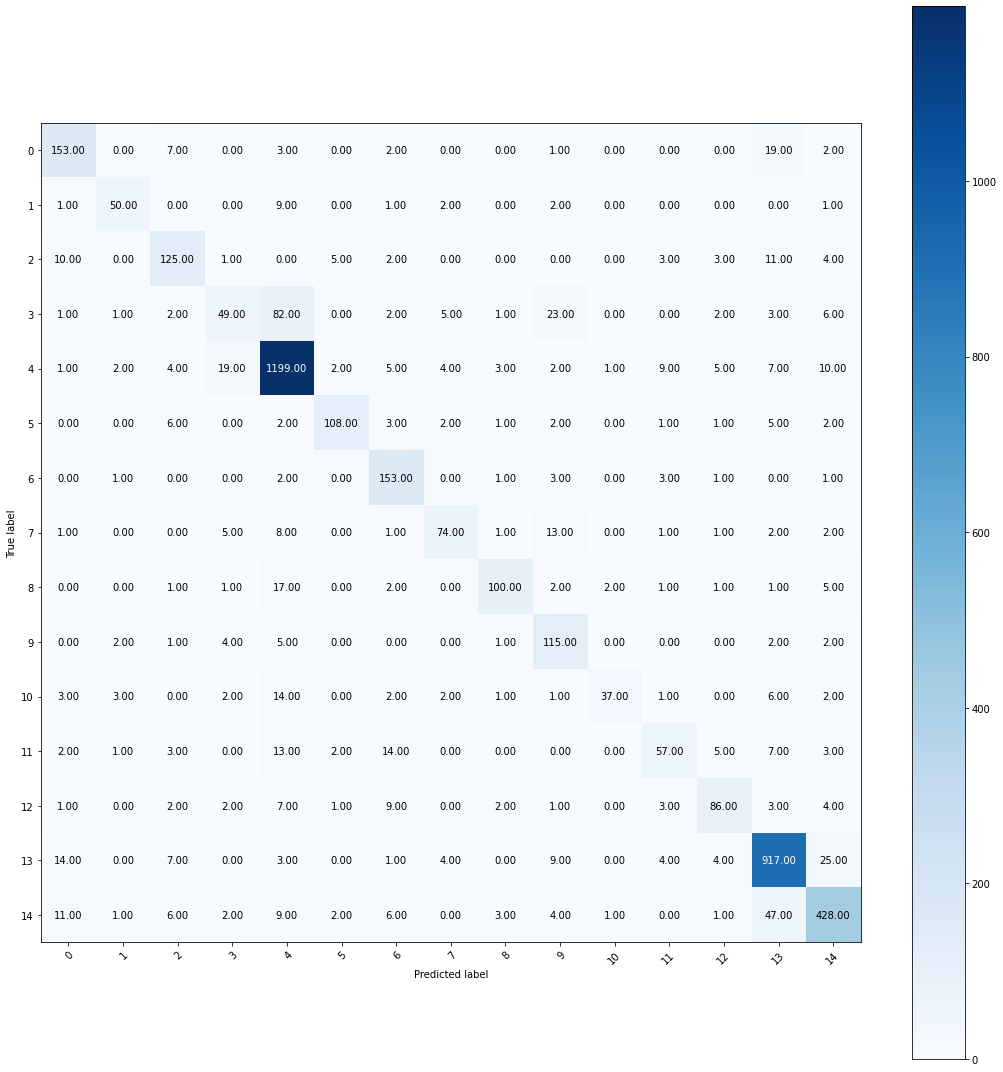

In [29]:
#Acurácia dos dados de teste e matrix de confusão

teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

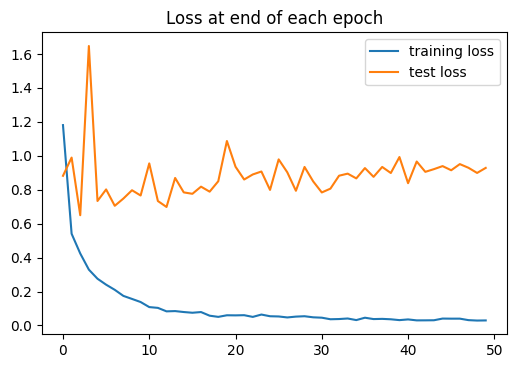

In [31]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

## Segundo Treinamento

In [35]:
args['num_epochs'] = 100

In [41]:
#Aplicação de outras transformações para data augmentation
transform = T.Compose([
    T.ToPILImage(),
    T.RandomGrayscale(0.5),
    T.RandomAutocontrast(0.5),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.Resize(224),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor()
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

train_iter, val_iter = load_data()

#Training
start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')


training on cuda:0
epoch 1, train loss 0.7685, train acc 0.781, test loss 0.7583, test acc 0.767, time 1.1 min
epoch 2, train loss 0.4624, train acc 0.857, test loss 0.6227, test acc 0.800, time 1.1 min
epoch 3, train loss 0.3649, train acc 0.882, test loss 0.5746, test acc 0.819, time 1.1 min
epoch 4, train loss 0.3281, train acc 0.892, test loss 0.5197, test acc 0.844, time 1.1 min
epoch 5, train loss 0.2833, train acc 0.907, test loss 0.5628, test acc 0.827, time 1.1 min
epoch 6, train loss 0.2574, train acc 0.915, test loss 0.5457, test acc 0.835, time 1.1 min
epoch 7, train loss 0.2467, train acc 0.918, test loss 0.5352, test acc 0.848, time 1.1 min
epoch 8, train loss 0.2160, train acc 0.926, test loss 0.5580, test acc 0.849, time 1.1 min
epoch 9, train loss 0.2023, train acc 0.930, test loss 0.8851, test acc 0.784, time 1.1 min
epoch 10, train loss 0.1839, train acc 0.938, test loss 0.5841, test acc 0.837, time 1.1 min
epoch 11, train loss 0.1880, train acc 0.934, test loss 0.59

epoch 97, train loss 0.0321, train acc 0.989, test loss 1.0248, test acc 0.822, time 1.0 min
epoch 98, train loss 0.0398, train acc 0.987, test loss 1.2465, test acc 0.794, time 1.0 min
epoch 99, train loss 0.0291, train acc 0.991, test loss 1.0023, test acc 0.823, time 1.1 min
epoch 100, train loss 0.0328, train acc 0.989, test loss 0.9848, test acc 0.827, time 1.1 min
Tempo de treinamento: 105.61 minutos


Accuracy: 81.61%, Precision: 0.75, Recall: 0.69, F1-Score: 0.71


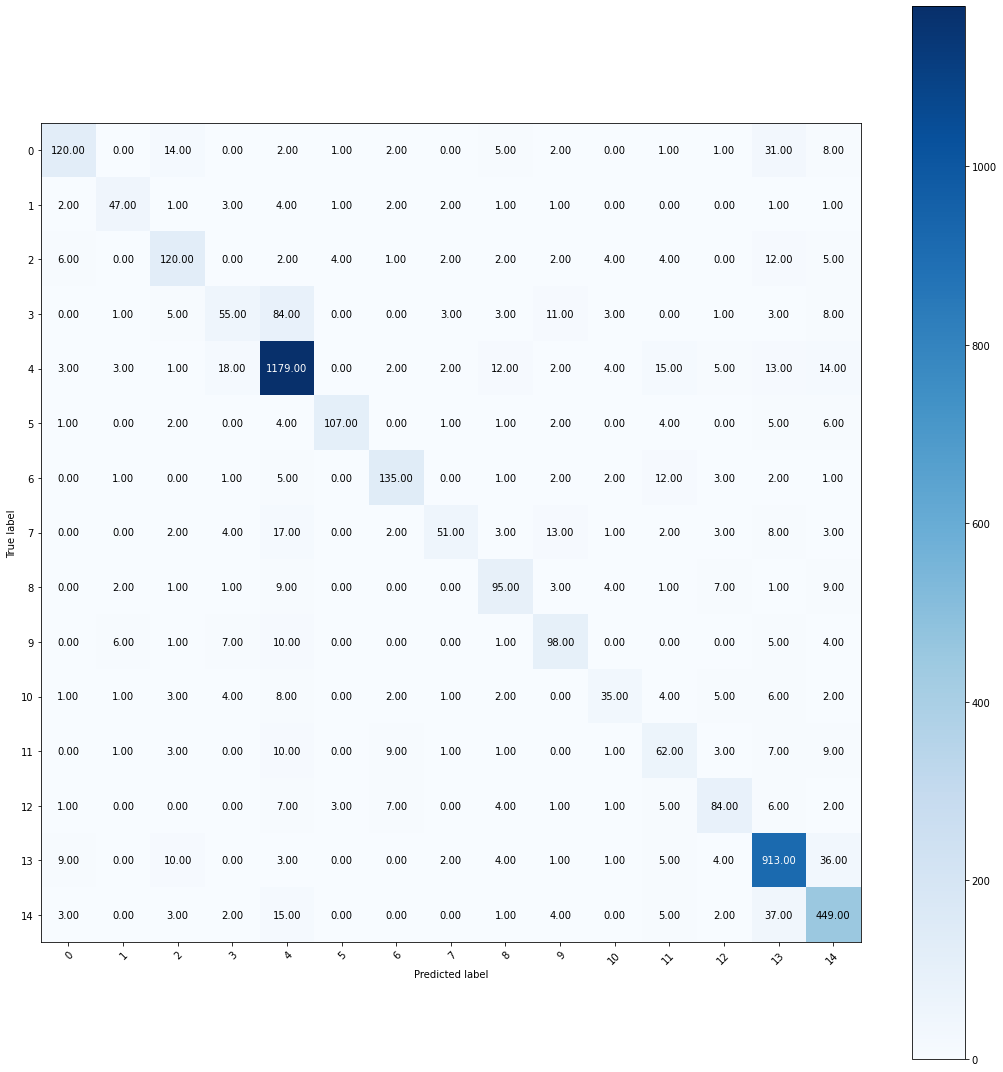

In [43]:
#Acurácia do conjunto de testes e matrix de confusão
teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

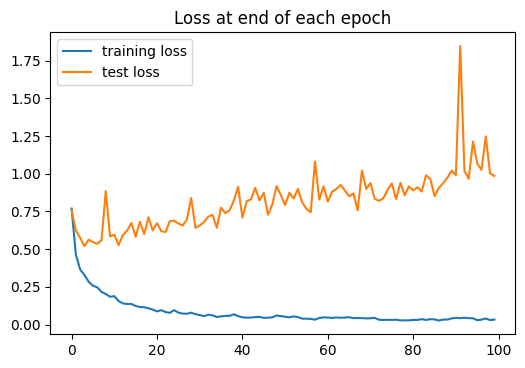

In [47]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses[50:], label = 'training loss')
plt.plot(test_losses[50:], label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

## Terceiro Treinamento 

In [ ]:
#Alterando a learning rate para 0.001

In [50]:
args

{'batch_size': 256,
 'num_workers': 4,
 'num_epochs': 100,
 'learning_rate': 0.001}

In [51]:
args['learning_rate'] = 0.0001

In [53]:
transform = T.Compose([
    T.ToPILImage(),
    T.RandomCrop(256, padding=4),
    T.RandomGrayscale(0.1),
    T.RandomAutocontrast(0.1),
    T.RandomHorizontalFlip(0.2),
    T.Resize(224),
    T.ToTensor(),
    T.Normalize([0, 0, 0], [1, 1, 1])
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

train_iter, val_iter = load_data()

#Training
start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')


training on cuda:0
epoch 1, train loss 1.2996, train acc 0.638, test loss 1.0606, test acc 0.682, time 0.5 min
epoch 2, train loss 0.8623, train acc 0.729, test loss 1.0166, test acc 0.698, time 0.5 min
epoch 3, train loss 0.7875, train acc 0.750, test loss 0.9817, test acc 0.702, time 0.5 min
epoch 4, train loss 0.7041, train acc 0.777, test loss 0.9733, test acc 0.711, time 0.5 min
epoch 5, train loss 0.6533, train acc 0.791, test loss 0.9017, test acc 0.742, time 0.5 min
epoch 6, train loss 0.6198, train acc 0.799, test loss 0.9008, test acc 0.732, time 0.5 min
epoch 7, train loss 0.5993, train acc 0.806, test loss 0.9345, test acc 0.729, time 0.5 min
epoch 8, train loss 0.5520, train acc 0.818, test loss 0.9517, test acc 0.728, time 0.5 min
epoch 9, train loss 0.5512, train acc 0.821, test loss 0.9752, test acc 0.721, time 0.5 min
epoch 10, train loss 0.5200, train acc 0.829, test loss 0.8771, test acc 0.748, time 0.5 min
epoch 11, train loss 0.4966, train acc 0.838, test loss 1.11

epoch 89, train loss 0.1472, train acc 0.950, test loss 1.2435, test acc 0.761, time 0.5 min
epoch 90, train loss 0.1370, train acc 0.953, test loss 1.2656, test acc 0.752, time 0.5 min
epoch 91, train loss 0.1435, train acc 0.952, test loss 1.3760, test acc 0.743, time 0.5 min
epoch 92, train loss 0.1335, train acc 0.955, test loss 1.2952, test acc 0.753, time 0.5 min
epoch 93, train loss 0.1455, train acc 0.951, test loss 1.3008, test acc 0.762, time 0.5 min
epoch 94, train loss 0.1394, train acc 0.950, test loss 1.3375, test acc 0.766, time 0.5 min
epoch 95, train loss 0.1415, train acc 0.951, test loss 1.3002, test acc 0.759, time 0.5 min
epoch 96, train loss 0.1347, train acc 0.953, test loss 1.2982, test acc 0.767, time 0.5 min
epoch 97, train loss 0.1300, train acc 0.957, test loss 1.2706, test acc 0.768, time 0.5 min
epoch 98, train loss 0.1382, train acc 0.952, test loss 1.3150, test acc 0.751, time 0.5 min
epoch 99, train loss 0.1338, train acc 0.952, test loss 1.3292, test a

Accuracy: 74.69%, Precision: 0.67, Recall: 0.62, F1-Score: 0.64


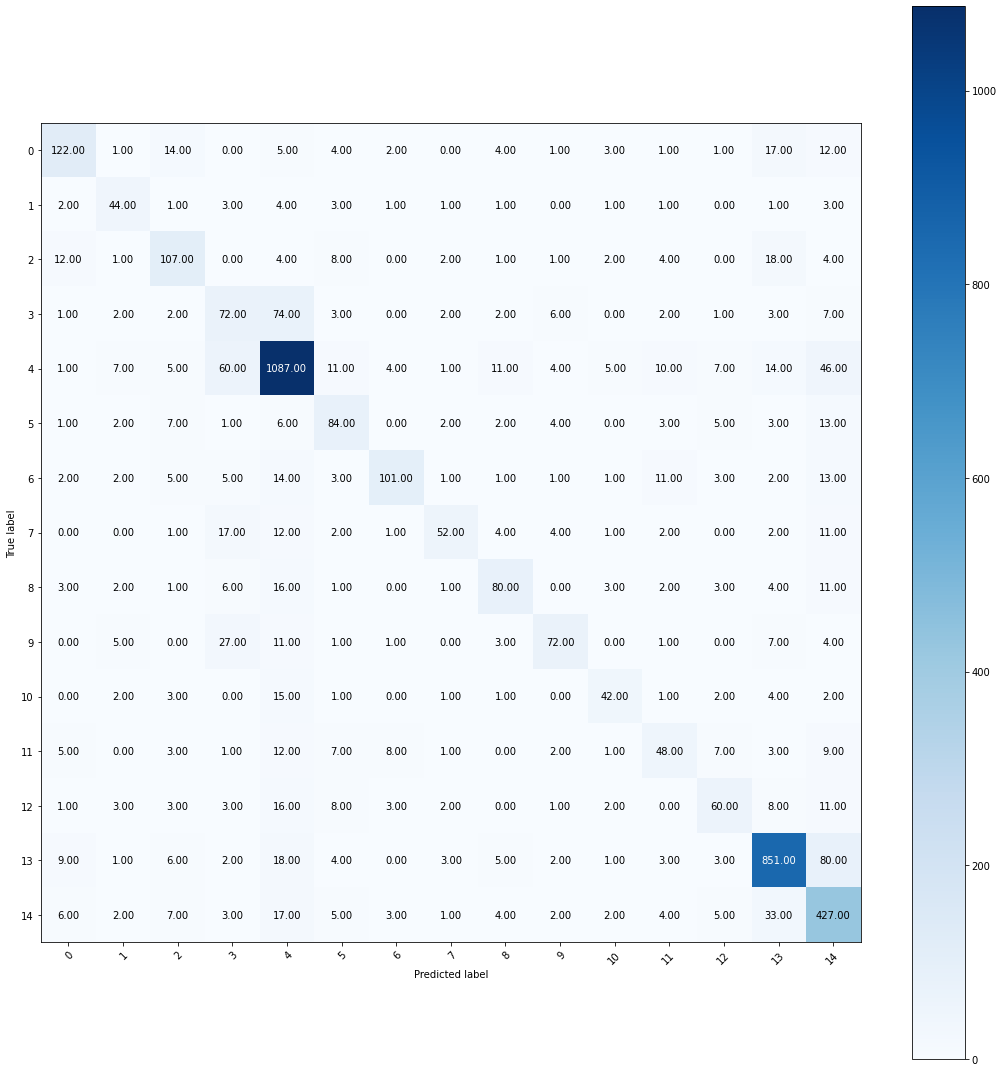

In [54]:
#Acurácia do conjunto de testes e matrix de confusão
teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

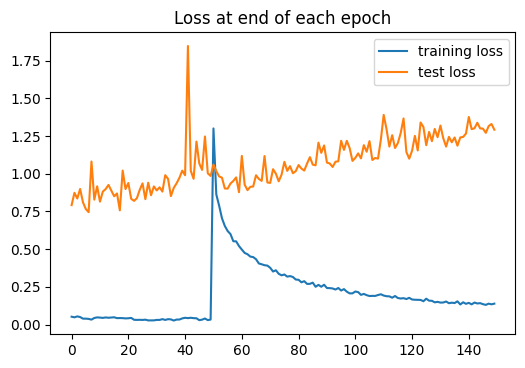

In [56]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses[100:], label = 'training loss')
plt.plot(test_losses[100:], label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

## Quarto Treinamento

In [68]:
#Diminuindo a learning rate e alterando o número de epochs para 200

In [61]:
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [62]:
args

{'batch_size': 256,
 'num_workers': 4,
 'num_epochs': 100,
 'learning_rate': 0.0001}

In [63]:
args['learning_rate'] = 0.0001
args['num_epochs'] = 200

In [ ]:
transform = T.Compose([
    T.ToPILImage(),
    T.RandomGrayscale(0.5),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.Resize(224),
    T.ColorJitter(brightness=0.4, contrast=0.25, saturation=0.25, hue=0.1),
    T.ToTensor(),
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

optimizer = optim.Adam(model.parameters(), lr = args['learning_rate'])
train_iter, val_iter = load_data()

#Training
start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')

training on cuda:0
epoch 1, train loss 0.3740, train acc 0.884, test loss 0.8088, test acc 0.801, time 1.0 min
epoch 2, train loss 0.2231, train acc 0.927, test loss 0.7378, test acc 0.823, time 1.0 min
epoch 3, train loss 0.1710, train acc 0.942, test loss 0.6886, test acc 0.830, time 1.0 min
epoch 4, train loss 0.1453, train acc 0.951, test loss 0.6557, test acc 0.839, time 1.0 min
epoch 5, train loss 0.1200, train acc 0.961, test loss 0.6653, test acc 0.847, time 1.0 min
epoch 6, train loss 0.1011, train acc 0.968, test loss 0.6754, test acc 0.846, time 1.0 min
epoch 7, train loss 0.0947, train acc 0.969, test loss 0.7144, test acc 0.839, time 1.0 min
epoch 8, train loss 0.0884, train acc 0.970, test loss 0.6938, test acc 0.843, time 1.0 min
epoch 9, train loss 0.0733, train acc 0.977, test loss 0.6978, test acc 0.846, time 1.0 min
epoch 10, train loss 0.0709, train acc 0.977, test loss 0.7006, test acc 0.847, time 1.0 min
epoch 11, train loss 0.0714, train acc 0.976, test loss 0.72

epoch 89, train loss 0.0060, train acc 0.998, test loss 0.8972, test acc 0.863, time 1.0 min
epoch 90, train loss 0.0044, train acc 0.999, test loss 0.9112, test acc 0.862, time 1.0 min
epoch 91, train loss 0.0047, train acc 0.999, test loss 0.9266, test acc 0.861, time 1.0 min
epoch 92, train loss 0.0050, train acc 0.999, test loss 0.9670, test acc 0.861, time 1.0 min
epoch 93, train loss 0.0044, train acc 0.999, test loss 0.9694, test acc 0.861, time 1.0 min
epoch 94, train loss 0.0044, train acc 0.999, test loss 0.9642, test acc 0.859, time 1.0 min
epoch 95, train loss 0.0052, train acc 0.998, test loss 0.9701, test acc 0.859, time 1.0 min
epoch 96, train loss 0.0048, train acc 0.999, test loss 0.9588, test acc 0.861, time 1.0 min
epoch 97, train loss 0.0038, train acc 0.999, test loss 0.9178, test acc 0.864, time 1.0 min
epoch 98, train loss 0.0033, train acc 0.999, test loss 0.9466, test acc 0.865, time 1.0 min
epoch 99, train loss 0.0041, train acc 0.999, test loss 0.9524, test a

Accuracy: 84.41%, Precision: 0.79, Recall: 0.74, F1-Score: 0.76


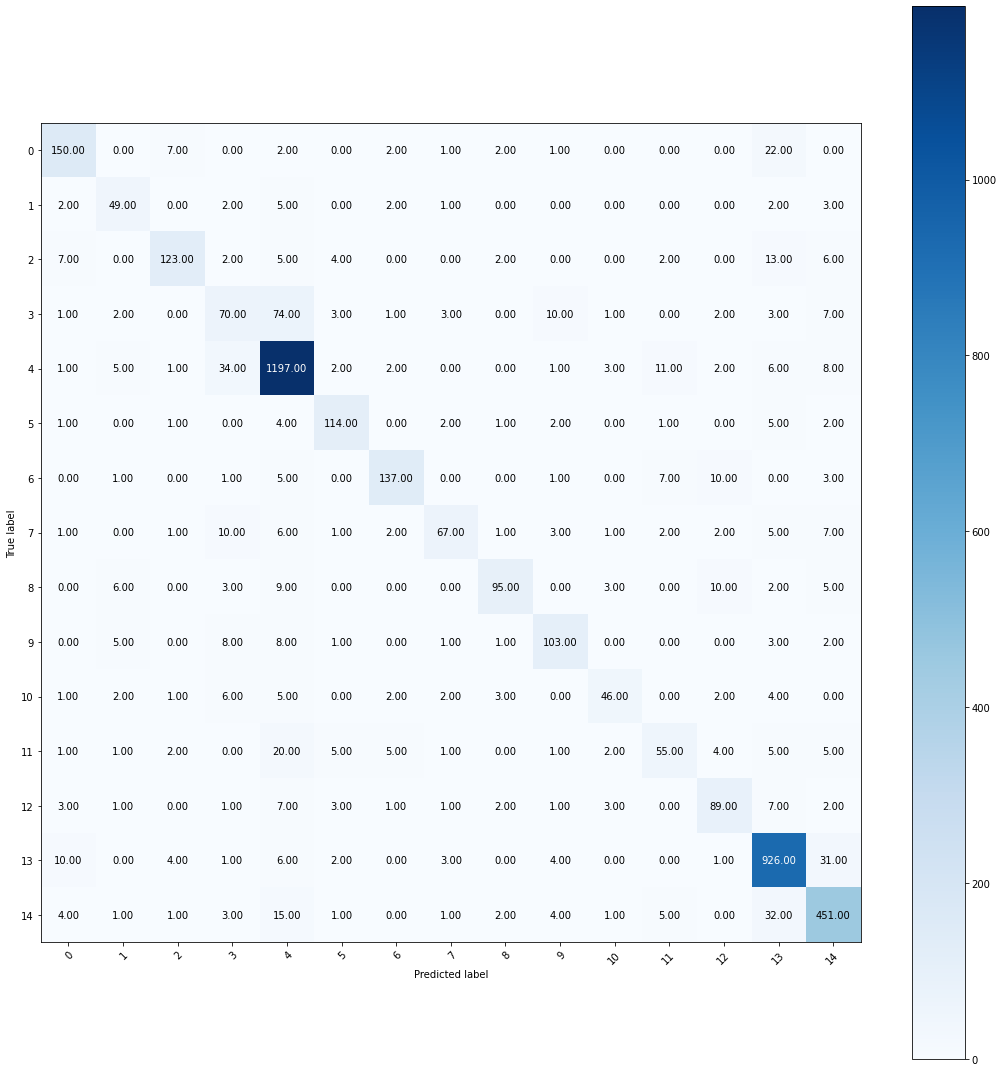

In [65]:
#Acurácia do conjunto de testes e matrix de confusão
teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

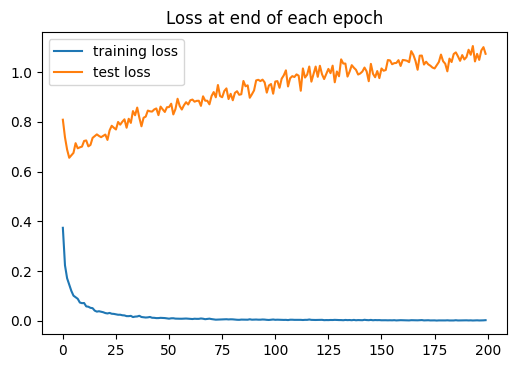

In [67]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

## Quarto Treinamento

In [11]:
transform = T.Compose([
    T.ToPILImage(),
    T.RandomGrayscale(0.5),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.Resize(224),
    T.ToTensor(),
])

train_dataset = AnimalImageDataset(csv_file = 'training_data_d1.csv', root_dir = '', transform = transform)
val_dataset = AnimalImageDataset(csv_file = 'validation_data_d1.csv', root_dir = '', transform = transform)

optimizer = optim.Adam(model.parameters(), lr = args['learning_rate'])
train_iter, val_iter = load_data()

#Training
start_time = time.time()

train_validate(model, train_iter, val_iter, optimizer, criterion, args['num_epochs'])

print(f'Tempo de treinamento: {((time.time() - start_time)/60):.2f} minutos')

NameError: name 'model' is not defined

Accuracy: 85.31%, Precision: 0.79, Recall: 0.75, F1-Score: 0.77


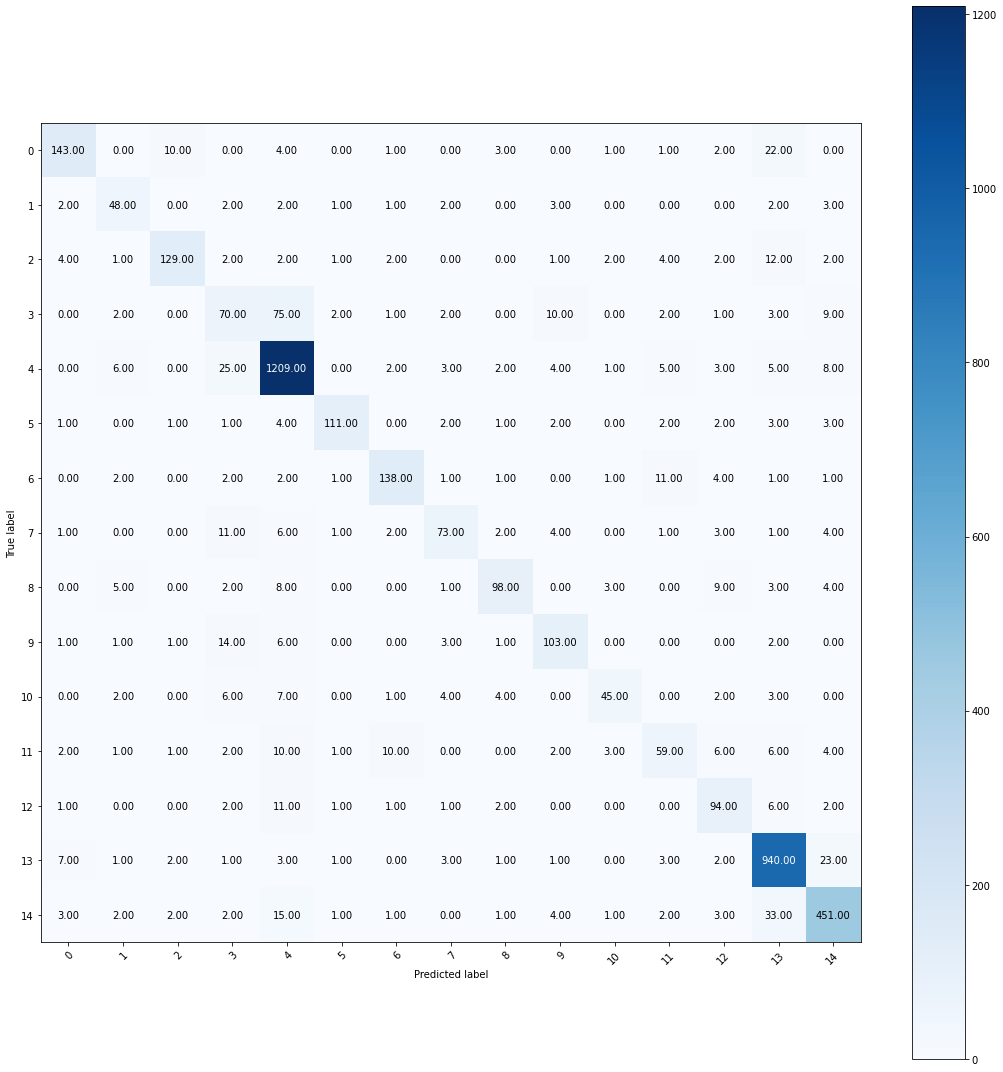

In [71]:
#Check Accuracy with test dataset and plot the confusion Matrix
teste_data = AnimalImageDataset(csv_file = "testing_data_d1.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

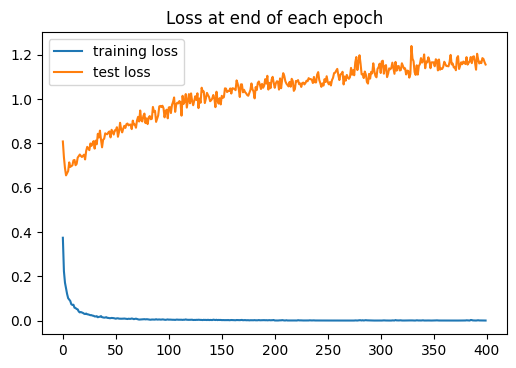

In [72]:
figure(figsize=(6, 4), dpi=100)

plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'test loss')
plt.title('Loss at end of each epoch')
plt.legend()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 87.01%, Precision: 0.78, Recall: 0.72, F1-Score: 0.75


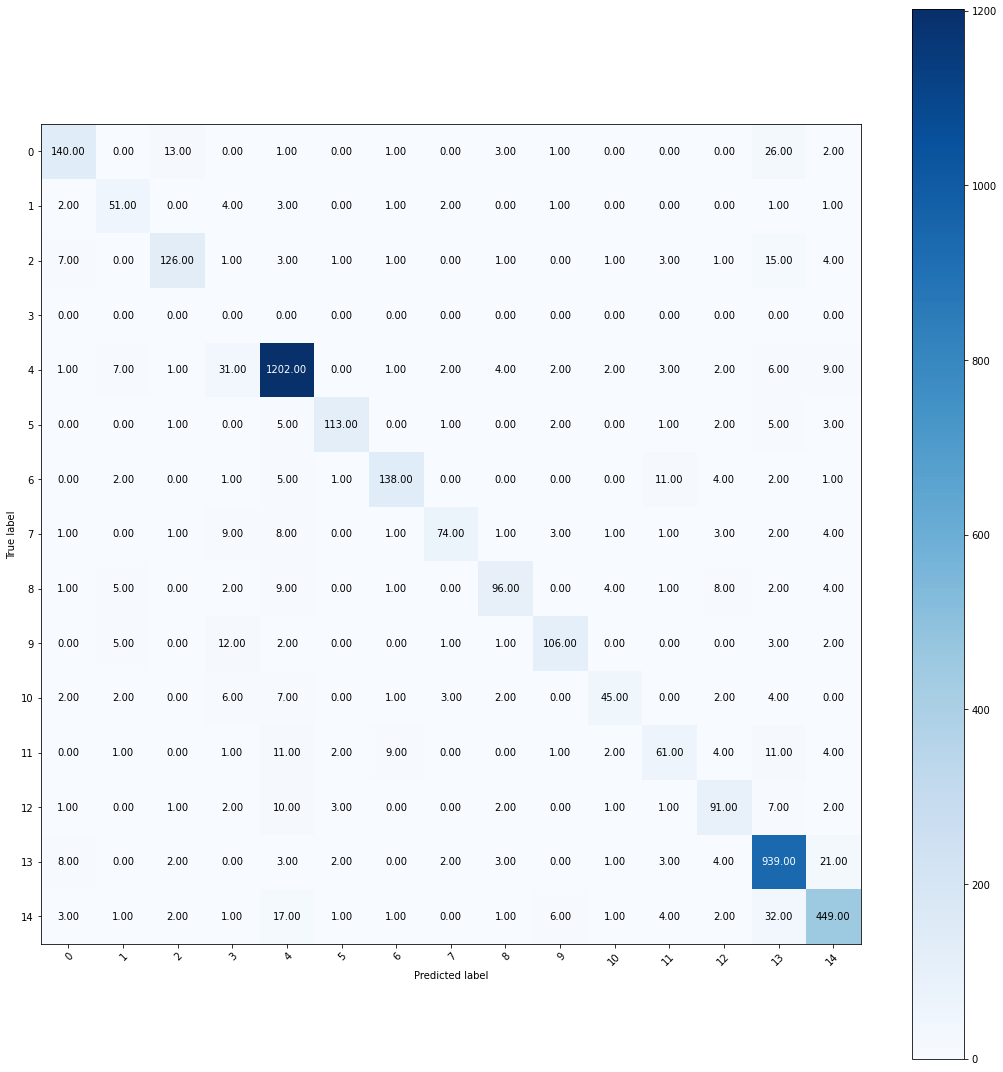

In [73]:
#Acurácia do conjunto de testes e matrix de confusão (Retirando a label 4)
teste_data = AnimalImageDataset(csv_file = "test_without_label14.csv",
                                root_dir = '',
                                transform = transform)

teste_loader = DataLoader(dataset=teste_data,
                          batch_size = args['batch_size'],
                          shuffle=False)

check_accuracy_test(teste_loader, model)

In [30]:
ls

Arquivos/            dados_treino_080423.csv   testing_data_d1.csv
CNN_-Copy1.ipynb     dados_treino_of.csv       train1_stats.csv
CNN_.ipynb           dados_val.of.csv          train_unknown_18_45.csv
CNN_Ajustes.ipynb    model_weights/            training_data_2903_50.csv
CNN_Ajustes_2.ipynb  test_unk_18_45.csv        training_data_d1.csv
CNN_RESNET.ipynb     test_without_label14.csv  validation_data_d1.csv
ZoombeeCNN.ipynb     testing_data_2903_50.csv


In [25]:
#Salvado o modelo gerado
path = 'model_alexnet.pth'

#Salva o modelo 
torch.save(model, path)

In [56]:
from sklearn import metrics
from sklearn import mixture

In [51]:
args = {
    'batch_size': 256,
    'num_workers': 4,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'num_classes': 50,
    'num_components': 4
}

In [64]:
treino = pd.read_csv("train_know.csv")

In [65]:
from collections import Counter


In [70]:
Counter(treino['label'])


Counter({48: 3009,
         10: 220,
         15: 3709,
         4: 527,
         49: 1615,
         17: 453,
         13: 477,
         14: 558,
         23: 407,
         34: 291,
         25: 421,
         30: 204,
         20: 263})

In [80]:
tu = pd.read_csv('train_know.csv')

In [83]:
tu['label']

0        48
1        48
2        10
3        48
4        15
         ..
12149    15
12150    48
12151    15
12152    48
12153    48
Name: label, Length: 12154, dtype: int64

In [87]:
valor = tu[tu['label'] == 45]['label']
print(valor)

Series([], Name: label, dtype: int64)


In [38]:
#Acurácia do conjunto de testes e matrix de confusão (Retirando a label 4)
train_known = AnimalImageDataset(csv_file = "train_know.csv",
                                root_dir = '',
                                transform = transform)

train_known_loaader = DataLoader(dataset=train_known,
                          batch_size = args['batch_size'],
                          shuffle = False)



train_uknown = AnimalImageDataset(csv_file = "train_unknown_18_45.csv",
                                  root_dir = '',
                                  transform = transform)


train_uknown_loader = DataLoader(dataset = train_uknown,
                                 batch_size = args['batch_size'],
                                 shuffle = False)


#check_accuracy_test(teste_loader, model)

In [51]:
def train_gmm(cls_list):
    
    model = mixture.GaussianMixture(random_state=12345)
    
    model.fit(cls_list)
    
    return model

In [40]:
import torch
import torchvision.models as models

#Importando modelo
path_model = 'model_weights/model_resnet18.pth'

model = torch.load(path_model)

In [50]:
def train_gmm(cls_list, n_components):
    model = mixture.GaussianMixture(n_components=n_components, random_state=12345)
    model.fit(cls_list.reshape(1, -1))
    return model

def train_gemos(mnist_train_loader, net):
    with torch.no_grad():
        # Setting network for evaluation mode (not computing gradients).
        net.eval()

        # Lists for output features.
        cls_list = [[] for c in range(args['num_classes'])]

        # Iterating over batches.
        for i, batch_data in enumerate(mnist_train_loader):

            # Obtaining images, labels and paths for batch.
            inps, labs = batch_data

            # Casting to cuda variables.
            inps = inps.to(device)

            # Forwarding.
            outs = net(inps)

            # Obtaining predictions.
            prds = outs.data.max(dim=1)[1].cpu().numpy()

            for j in range(prds.shape[0]):
                prds_cls = prds[j]
                labs_cls = labs[j].detach().cpu().item()

                if prds_cls == labs_cls:
                    cls_list[labs_cls].append(outs[j].detach().cpu().numpy().ravel())

        model_list = []

        for c in range(args['num_classes']):
            print('Training model for class %d...' % (c))
            model_list.append(train_gmm(np.asarray(cls_list[c]), args['num_components']))

        return model_list

model_list = train_gemos(train_known_loaader, model)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument weight in method wrapper__cudnn_convolution)

In [45]:
def train_gemos(train_loader, model):
    
    with torch.no_grad():
        
        # Setting network for evaluation mode (not computing gradients).
        model.eval()

        # Lists for output features.
        cls_list = [[] for c in range(args['num_classes'])]

        # Iterating over batches.
        for X, y in train_loader:
            
            # Casting to cuda variables.
            X = X.to(device)
            y = y.to(device)

            # Forwarding.
            y_pred = model(X)

            # Obtaining predictions.
            prds = y_pred.data.max(dim=1)[1].cpu().numpy()

        for j in range(prds.shape[0]):
                prds_cls = prds[j]
                labs_cls = y[j].detach().cpu().item()

                if prds_cls == labs_cls:
                    cls_list[labs_cls].append(y_pred[j].detach().cpu().numpy())

        model_list = []

        for c in range(args['num_classes']):

            if(np.asarray(cls_list[c]).size > 0):
                model_list.append(train_gmm(np.asarray(cls_list[c])))
                print('Training model for class %d...' % (c))
            
        return model_list

model_list = train_gemos(train_known_loaader, model)

IndexError: list index out of range

In [31]:
import random

In [40]:
def test_gemos(test_loader, net, model_list):
    
    with torch.no_grad():
        
        # Setting network for evaluation mode (not computing gradients).
        net.eval()

        # Lists for losses and metrics.
        scr_list = []
        prd_list = []
        lab_list = []
        out_list = []
        inps_list = []
        inps_prd = []
        inps_scr = []
        inps_lab = []

        # Iterating over batches.
        for i, batch_data in enumerate(test_loader):


            # Obtaining images, labels and paths for batch.
            inps, labs = batch_data

            #if inps.size(1) > 1:
            #    inps = inps[:, 0, :, :].unsqueeze(1)

            # Casting to cuda variables.
            inps = inps.to(device)
            labs = labs.to(device)

            rand = random.randint(0, 199)

            # Forwarding.
            outs = net(inps)

            # Obtaining predictions.
            prds = outs.data.max(dim=1)[1].cpu().numpy()
            print(prds)

            for j in range(prds.shape[0]):

                prds_cls = prds[j]

                print(prds_cls)
                print(outs)

                if(prds_cls == 4):
                    prds_cls = 0
                elif(prds_cls == 10):
                    prds_cls = 1
                elif(prds_cls == 13):
                    prds_cls = 2
                elif(prds_cls == 14):
                    prds_cls = 3
                elif(prds_cls == 15):
                    prds_cls = 4
                elif(prds_cls == 17):
                    prds_cls = 5
                elif(prds_cls == 20):
                    prds_cls = 6
                elif(prds_cls == 23):
                    prds_cls = 7
                elif(prds_cls == 25):
                    prds_cls = 8
                elif(prds_cls == 30):
                    prds_cls = 9
                elif(prds_cls == 34):
                    prds_cls = 10
                elif(prds_cls == 48):
                    prds_cls = 11
                elif(prds_cls == 49 or prds_cls == 45):
                    prds_cls = 12
                elif(prds_cls == 18):
                    prds_cls = 12


                outs_cls = outs[j].detach().cpu().numpy().ravel()

                print(prds_cls)
                #print(np.expand_dims(outs_cls, 0))


                scr = model_list[prds_cls].score(np.expand_dims(outs_cls, 0))

                scr_list.append(scr)

                out_list.append(outs_cls)

                if j == rand:
                  inps_list.append(inps[j])
                  inps_prd.append(prds[j])
                  inps_scr.append(scr)
                  inps_lab.append(labs[j])

            # Updating lists.
            prd_list.extend(prds.tolist())
            lab_list.extend(labs.detach().cpu().numpy().tolist())

        return scr_list, prd_list, lab_list, out_list, inps_list, inps_prd, inps_scr, inps_lab

print('Processing MNIST...')
mnist_scr_list, mnist_prd_list, mnist_lab_list, mnist_out_list, mnist_inps, mnist_inps_prd, mnist_inps_scr, mnist_inps_lab = test_gemos(train_known_loaader, model, model_list)

print('Processing OMNIGLOT...')
omniglot_scr_list, omniglot_prd_list, omniglot_lab_list, omniglot_out_list, omniglot_inps, omniglot_inps_prd, omniglot_inps_scr, omniglot_inps_lab = test_gemos(train_uknown_loader, model, model_list)

Processing MNIST...
[346 977  29 921 353 669 179 353 345 353 149 340 435 977 345 354 117 350
 425 354 354 354 902 921 921 340 405 958 549 977 958 354 354 351 549 478
 353 340   4 351 405 111 978 921 883 353 279   4 386 385 478 975 908 978
 354 908 101 346 347 111 354 111 354 405 347 279 353 970   4 101 354 921
 354 386 354 908 148 270 405 975 975 340 111 331 354 176 970 975 354 978
  67 273 755 446 346 405 977 340 101 101   4 977 703 111 352 970 649 354
 354 351 347 669 353 999 921 270 354 730 111 340 977 386 340  34 749 356
 976 999 399 354 386 296 883 425 425 353 921 405 669 340 111 978 346 101
 908 623 405 425 672 148 749 354 330 353 354 755 273 669 970 354 975 101
 351 340 672 549 970 425 883 347 578 353 980 978 353 802 351 111 795 549
 353 755 981 913 354 977 353 913 510 568 340 340 549 425 921 549 178 354
 669 549 342 353 296 749 978 908 549 347 549 293 351  51 270 730 405 728
 353 353 111 972 755 970 354 699 425 354 354 399 354 343 350 970 782 979
 794 669 978 346 405 978 978 90

IndexError: list index out of range

In [ ]:
#Treinamento e validação
def train_validate(model, train_iter, test_iter, optimizer, loss, num_epochs):
    print('training on', device)
    for epoch in range(num_epochs):
        model.train()
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            optimizer.zero_grad()
            l = loss(y_pred, y).sum()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_pred.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, model, loss)
        train_losses.append(train_l_sum / len(train_iter))
        train_correct.append(train_acc_sum / n)
        test_losses.append(test_loss)
        test_correct.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, ''test acc %.3f, time %.1f min' % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss, test_acc, (time.time() - start) / 60))

In [48]:
from sklearn.mixture import GaussianMixture
import time

def train_gmm(data, n_components):
    model = GaussianMixture(n_components=n_components, random_state=12345)
    model.fit(data)
    return model

def train_gemos(model, train_iter, optimizer, loss, num_epochs):
    print('training on', device)
    model_list = []  # Lista para armazenar os modelos treinados
    train_losses = []  # Lista para armazenar as perdas de treinamento


    # Treinamento dos modelos de mistura de gaussianas
    for c in range(args['num_classes']):
        print('Training model for class %d...' % (c))
        data = []  # Lista para armazenar as características correspondentes a uma classe específica

        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            prds_cls = y_pred.argmax(dim=1)  # Previsões de classe
            labs_cls = y  # Rótulos de classe

            for prd, lab in zip(prds_cls, labs_cls):
                if prd == lab:
                    data.append(y_pred.detach().cpu().numpy().ravel())  # Adiciona as características à lista

        model_list.append(train_gmm(np.asarray(data), args['num_components']))  # Treina o modelo de mistura de gaussianas para a classe atual

    return model_list, train_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
train_validate(model, train_known, val_iter, optimizer, criterion, args['num_epochs'])

NameError: name 'train_known' is not defined